## Intro to Domino Project - Scheduled Reports

See the getting started [docs](https://docs.dominodatalab.com/en/4.1/get_started/index.html) to set up this project. This notebook outlines step 7, using Jupyter to load, explore, and transform some data on a regular basis. This follows the same format as the notebook 'Forecast_Power_Generation' with the addition of the cell below which pulls in new predictions for the combined cycle gas turbine generations. 

See [this document](https://www.bmreports.com/bmrs/?q=generation/fueltype/current) for information on the data and column headers.

In [1]:
#Collect New Predictions for Combined Cycle Gas Turbine Generations
import datetime
today = datetime.datetime.today().strftime('%Y-%m-%d')
one_month = (datetime.datetime.today() - datetime.timedelta(30)).strftime('%Y-%m-%d')
!curl -o data.csv "https://www.bmreports.com/bmrs/?q=ajax/filter_csv_download/FUELHH/csv/FromDate%3D{one_month}%26ToDate%3D{today}/&filename=GenerationbyFuelType_20191002_1657" 2>/dev/null

In [2]:
#import the packages we need
%matplotlib inline
import pandas as pd
import datetime

In [3]:
#read in our data
df = pd.read_csv('data.csv', skiprows=1, skipfooter=1, header=None, engine='python')
df = df.iloc[:,0:18]

In [4]:
#rename the columns
df = df.iloc[:,0:18]
df.columns = ['HDF', 'date', 'half_hour_increment',
              'CCGT', 'OIL', 'COAL', 'NUCLEAR',
              'WIND', 'PS', 'NPSHYD', 'OCGT',
              'OTHER', 'INTFR', 'INTIRL', 'INTNED',
               'INTEW', 'BIOMASS', 'INTEM']

#look at our data frame
df.head()

,HDF,date,half_hour_increment,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,20201114,1,5931,0,0,5447,7574,0,458,1,213,1512,214,740,444,870,678
1,FUELHH,20201114,2,6112,0,0,5447,7434,0,461,96,212,1510,214,738,504,864,678
2,FUELHH,20201114,3,6116,0,0,5436,7142,0,458,99,214,1412,214,694,468,872,656
3,FUELHH,20201114,4,5686,0,0,5446,6826,0,457,99,211,1410,214,688,504,870,656
4,FUELHH,20201114,5,5649,0,0,5447,6539,0,448,99,213,1412,214,284,504,870,646


In [5]:
#Create a new column datetime that represents the starting datetime of the measured increment
df['datetime'] = pd.to_datetime(df['date'], format="%Y%m%d")
df['datetime'] = df.apply(lambda x:x['datetime']+ datetime.timedelta(minutes=30*(int(x['half_hour_increment'])-1)), 
                          axis = 1)

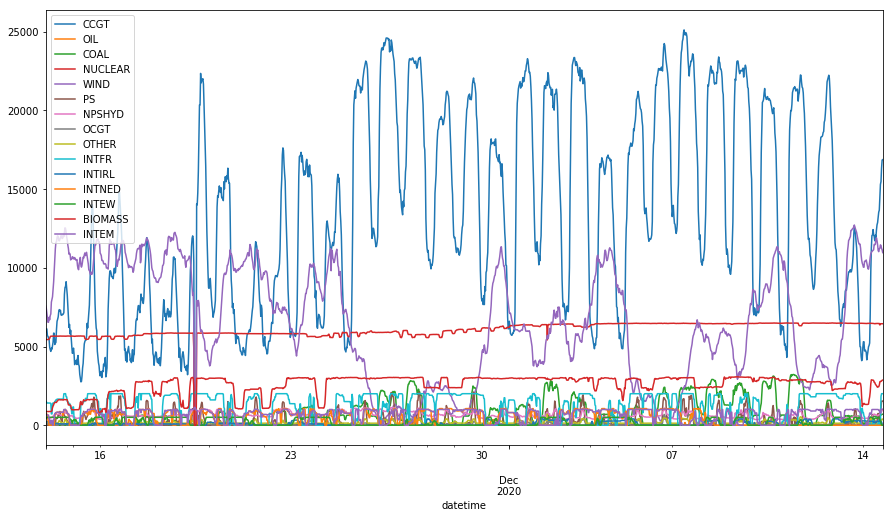

In [6]:
#Visualize the data to see how each fuel type is used during the day by plotting the data
df.drop(['HDF', 'date', 'half_hour_increment'], axis = 1).set_index('datetime').plot(figsize=(15,8));

### Train our model
The CCGT column representing “combined-cycle gas turbines” seems to be the most interesting. It generates a lot of energy and is very volatile.

We will concentrate on this column and try to predict the power generation from this fuel source.

In [7]:
#install Facebook Prophet. Note that this install will not persist beyond this session
!sudo -H pip install -q --disable-pip-version-check "pystan==2.17.1.0" "plotly<4.0.0"
!pip install -q --disable-pip-version-check fbprophet

In [8]:
#Prep our data - for Facebook Prophet, the time series data needs to be in a DataFrame with 2 columns named ds and y
df_for_prophet = df[['datetime', 'CCGT']].rename(columns = {'datetime':'ds', 'CCGT':'y'})

In [9]:
#Split the dataset into train and test sets
X = df_for_prophet.copy()
y = df_for_prophet['y']

proportion_in_training = 0.8
split_index = int(proportion_in_training*len(y))

X_train, y_train = X.iloc[:split_index], y.iloc[:split_index]
X_test, y_test = X.iloc[split_index:], y.iloc[split_index:]

In [10]:
#mport Facebook Prophet and fit a model
from fbprophet import Prophet

m = Prophet(yearly_seasonality=False)
m.fit(X_train);

/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [11]:
#Make a DataFrame to hold the predictions and predict future values of CCGT power generation

future = m.make_future_dataframe(periods=int(len(y_test)/2), freq='H')
forecast = m.predict(future)

#inspect the dataframe
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1323,2020-12-14 13:30:00,29643.896092,25056.479387,34339.305288
1324,2020-12-14 14:30:00,30316.343038,25558.162137,35081.914154
1325,2020-12-14 15:30:00,30978.314652,26107.053662,35619.147569
1326,2020-12-14 16:30:00,31477.731793,27075.521454,35999.470079
1327,2020-12-14 17:30:00,31640.165972,26680.579120,36308.012386


<Figure size 432x288 with 0 Axes>

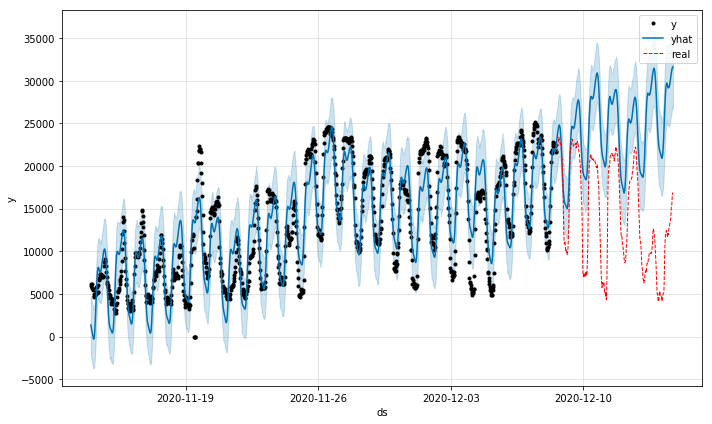

In [12]:
#Plot the fitted line with the training and test data
import matplotlib.pyplot as plt

plt.gcf();
fig = m.plot(forecast);
plt.plot(X_test['ds'].dt.to_pydatetime(), X_test['y'], 'r', linewidth = 1, linestyle = '--', label = 'real');
plt.legend();

### Export trained model
Trained models are meant to be used. There is no reason to re-train the model each time you use the model. Export or serialize the model to a file to load and reuse the model later. In Python, the pickle module implements protocols for serializing and de-serializing objects.

In [13]:
#export the trained model as a pickle file for later use
import pickle
m.stan_backend.logger = None    #uncomment if using Python 3.6 and fbprophet==0.6
with open("model.pkl", "wb") as f:
      pickle.dump(m, f)